## Recurrent Neural Networks

In [1]:
# FIX ALL THE RANDOM VALUES TO GET REPRODUCIBLE RESULTS
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

# SET NICE PLOTTING
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import h5py
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling1D, GRU 
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
workspace = '/home/speakers/isobieraj/workspace'

hdf5_path = os.path.join(workspace,'dataset.hdf5') 
modelfolder = os.path.join(workspace,'models')
scalerpath = os.path.join(workspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler = pickle.load(open(scalerpath, 'rb'), encoding='latin1') #python2 object to python3

#scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

In [7]:
def build_rnn(n_frames=n_frames, n_features=n_features,
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features), dtype='float32')
        
    y = GRU(50, return_sequences = True)(x)
    y = Dropout(0.5)(y)    
    
    y = GRU(50, return_sequences = True)(y)
    y = Dropout(0.5)(y)
    
    y = GlobalAveragePooling1D()(y)
     
    y = Dense(n_classes, activation='softmax')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_rnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 173, 50)           13650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 50)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 173, 50)           15150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 173, 50)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total para

In [9]:
from keras.utils import plot_model
plot_model(m, to_file='figures/rnn_model_shape.png', show_shapes=True)

<img src='figures/rnn_model_shape.png'> 

In [10]:
adam= keras.optimizers.Adam(lr=0.0005, decay=1e-4)
m.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
model_checkpoint = ModelCheckpoint(
            os.path.join(modelfolder, 
                    'rnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
            monitor='val_loss', 
            save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [12]:
history = m.fit(x=np.array(X_train_scaled), y=y_train, batch_size=300,
                    epochs=200, verbose=True,          
                    callbacks=callbacks,
                    validation_data=(np.array(X_val_scaled), y_val),
                    shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 27s 4ms/step - loss: 2.2371 - acc: 0.1555 - val_loss: 2.0545 - val_acc: 0.2806
Epoch 2/200
7079/7079 [==============================] - 24s 3ms/step - loss: 2.0188 - acc: 0.2957 - val_loss: 1.8642 - val_acc: 0.3211
Epoch 3/200
7079/7079 [==============================] - 25s 3ms/step - loss: 1.8521 - acc: 0.3512 - val_loss: 1.7082 - val_acc: 0.3272
Epoch 4/200
7079/7079 [==============================] - 25s 4ms/step - loss: 1.7187 - acc: 0.3869 - val_loss: 1.6301 - val_acc: 0.3358
Epoch 5/200
7079/7079 [==============================] - 25s 4ms/step - loss: 1.6213 - acc: 0.4245 - val_loss: 1.5864 - val_acc: 0.3346
Epoch 6/200
7079/7079 [==============================] - 25s 4ms/step - loss: 1.5401 - acc: 0.4604 - val_loss: 1.5220 - val_acc: 0.3689
Epoch 7/200
7079/7079 [==============================] - 24s 3ms/step - loss: 1.4541 - acc: 0.4975 - val_loss: 1.4939 - val_acc: 0.3615
E

7079/7079 [==============================] - 34s 5ms/step - loss: 0.4121 - acc: 0.8692 - val_loss: 1.7791 - val_acc: 0.6201
Epoch 00060: early stopping


Text(0,0.5,'Loss')

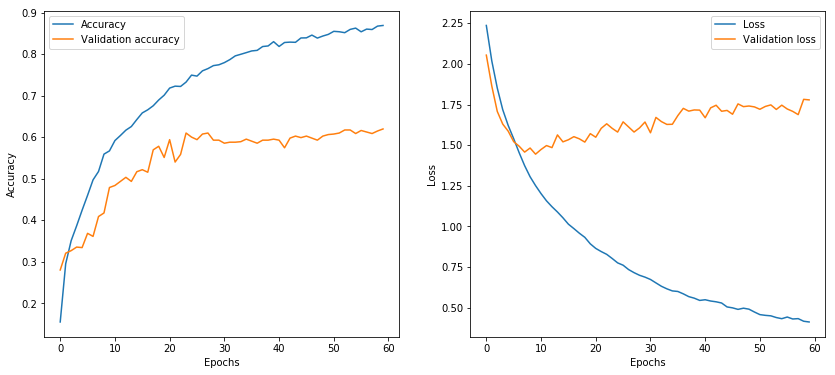

In [13]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [14]:
prediction = m.predict(np.array(X_test_scaled), batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 2s 2ms/step


Accuracy: 0.57


Text(0.5,32.0938,'Predicted label')

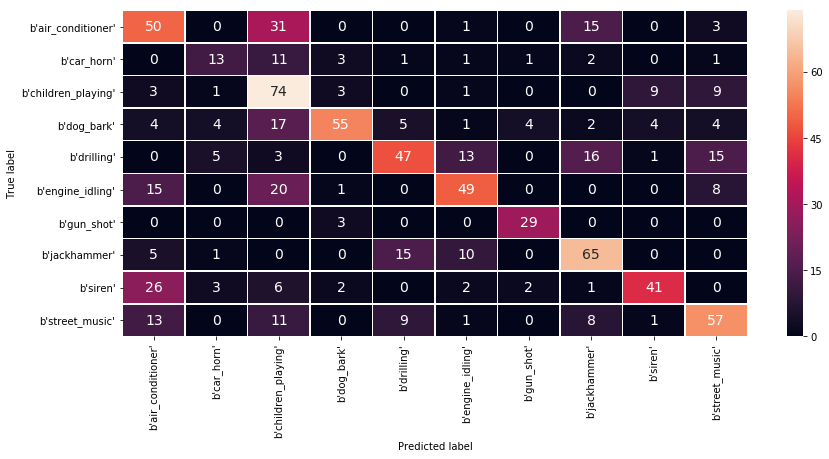

In [15]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, 
            yticklabels=label_list,xticklabels=label_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')